In [98]:
%pylab inline
import glob
import spams
import pandas as pd
from numpy.linalg import pinv as moore_penrose_inv
from numpy.linalg import svd, eig
from tqdm import tqdm
import seaborn as sns
sns.set_context('paper', font_scale=2)
sns.set_style('white')

Populating the interactive namespace from numpy and matplotlib


/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/scanpy/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'matrix', 'rank']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [6]:
prefix = '/home/cmb-panasas2/skchoudh/github_projects/EE-546-project/cross-species-data/'
for f in sorted(glob.glob('{}/*.tsv'.format(prefix))):
    df = pd.read_table(f)
    df = df.drop(columns=['target_id'])
    matrix = df.values
    colsize = matrix.shape[1]
    rank = matrix_rank(matrix)
    print('{} : Array colsize: {} | rank: {}'.format(f.split('/')[-1], colsize, rank))

SRP007412-gallus_gallus.tsv : Array colsize: 12 | rank: 12
SRP007412-gorilla_gorilla.tsv : Array colsize: 11 | rank: 11
SRP007412-homo_sapiens.tsv : Array colsize: 18 | rank: 18
SRP007412-macaca_mulatta.tsv : Array colsize: 13 | rank: 13
SRP007412-monodelphis_domestica.tsv : Array colsize: 12 | rank: 12
SRP007412-mus_musculus.tsv : Array colsize: 17 | rank: 17
SRP007412-ornithorhynchus_anatinus.tsv : Array colsize: 12 | rank: 12
SRP007412-pan_paniscus.tsv : Array colsize: 12 | rank: 12
SRP007412-pan_troglodytes.tsv : Array colsize: 15 | rank: 15
SRP007412-pongo_abelii.tsv : Array colsize: 9 | rank: 9
SRP016501-bos_taurus.tsv : Array colsize: 27 | rank: 27
SRP016501-gallus_gallus.tsv : Array colsize: 27 | rank: 27
SRP016501-macaca_mulatta.tsv : Array colsize: 27 | rank: 27
SRP016501-mus_musculus.tsv : Array colsize: 26 | rank: 26
SRP016501-rattus_norvegicus.tsv : Array colsize: 27 | rank: 27


In [69]:
def SVD_impute(df):
    """Perform SVD imputing.
    
    
    Parameters
    ----------
    matrix: array_like
            Array with rows as genes and columns as tissues/samples
            with nans for missing values
    
    Returns
    -------
    filled_matrix: array_like
                   Imputed matrix with entries filled by relying on eigengenes    
    """
    
    null_idx = pd.isnull(df).any(1).nonzero()[0]

    full_matrix = df.values
    non_null_matrix  = df.dropna().values
    U, S, V_T = np.linalg.svd(non_null_matrix)
    V =  V_T.T
    
    for index in null_idx:
        x = full_matrix[index,:]

        # index of entries where the row is nan
        row_na_idx = np.where(np.isnan(x))
        
        # index of entries where the row is not nan        
        row_not_na_idx = np.where(~np.isnan(x))
        
        
        # entries from row which are not nan        
        x_star_not_na = x[row_not_na_idx]
        
         # entries from row which are not nan        
        x_star_na = x[row_na_idx]

        # Eigen genes corresponding to index 
        # of locations (columns) in row x which are nan
        V_star_na = np.delete(V, row_not_na_idx, 0)
        
        
        # Delete rows from V, corresponding to index 
        # of locations (columns) in row x which are nan
        # We will use these to project the row with complete
        V_star_not_na = np.delete(V, row_na_idx, 0)


        gram = np.dot(V_star_not_na.T, V_star_not_na)
        coeff = np.dot(np.linalg.pinv(gram), V_star_not_na.T)

        beta = np.dot(coeff, x_star_not_na)
        
        # xhat = V_J \beta
        x_missing = np.dot(V_star_na, beta)
        
        # Fill in the missing entries
        full_matrix[index, row_na_idx] = x_missing
    return full_matrix

def plot_SVD_utils(U, S, VT):
    V = VT.T
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(30, 20))
    ax = axes[0, 0]
    sns.heatmap(V, square=True, cmap='RdBu', ax=ax, cbar=False)
    
    ax = axes[0, 1]
    sns.barplot(x=np.arange(1, len(S)+1), y=S**2/np.sum(S**2), ax=ax, color=sns.color_palette('Set2')[1])
    
    ax = axes[0, 2]
    ax.plot(V[:, 0], marker='o')
    
    ax = axes[1, 0]
    ax.plot(V[:, 1], marker='o')
    
    ax = axes[1, 1]
    ax.plot(V[:, 2], marker='o')
    
    ax = axes[1, 2]
    ax.plot(V[:, 3], marker='o')
    
    
    
    
    

In [76]:
def einsum_row_norm(a):
    return np.sqrt(np.einsum('ij,ij->i', a, a))

def einsum_col_norm(a):
    return np.sqrt(np.einsum('ij,ij->j', a, a))


def ho_SVD(list_of_X):
    """ Perform higher order SVD
    
    list_of_X: list
               [X_1, X_2, X_3, ..., X_n] size (n x m)
    
    """
    # Step 1
    # A_i = X_i^T X_i
    # A_inv = moore_penrose_inv(A_i)
    A = []
    N = len(list_of_X)
    A_inv = []
    for X in list_of_X:
        A_i = np.dot(X.T, X)
        A.append(A_i)
        A_inv.append(np.linalg.inv((A_i)))
    # Step 2
    # W = 1/N(N-1) * sum_{i=1}^jn sum_{j>i}^N A_i moore_penrose_inv(A_j) + A_j moore_penrose_inv(A_i)
    W = 0
    
    for i in range(N):
        for j in range(i+1, N):
            W = W + (np.dot(A[i], A_inv[j]) + np.dot(A[j], A_inv[i]))
    W =  W/(N*(N-1))
    
    # Step 3
    # Eigen decomposition of W?
    # WV = V\Lambda
    # V= (v_1, v_2, ..., v_n)
    # ||v||_k =1, but V is not necesarrily orthonormal
    # But we don't
    
    eigen_values, V = eig(W)

    idx = eigen_values.argsort()[::-1]   
    eigen_values = eigen_values[idx]
    V = V[:,idx]
    
    
    # Step 4
    # solve for  VB_i = X_i^T
     #Calculate the Bi matrices
   
    B = []
    U = []
    sigmas = []
    for X in list_of_X:
        #B_i = spams.omp( np.asfortranarray(X.T), V, lambda1=0, numThreads = 24)]
        # VB.T = X.T
        B_i = np.dot(np.linalg.inv(V), X.T).T
        B.append(B_i)
        sigma_i  = np.linalg.norm(B_i, axis=0) #einsum_col_norm(B)
        U_i = B_i/sigma_i 
        sigmas.append(sigma_i)
        U.append(U_i)
    return U, sigmas, V
    

In [59]:
df = pd.read_table('/home/cmb-panasas2/skchoudh/github_projects/EE-546-project/cross-species-data/SRP016501-rattus_norvegicus.tsv')
df = df.drop(columns=['target_id'])
matrix1 =  np.asfortranarray(df.values)

df = pd.read_table('/home/cmb-panasas2/skchoudh/github_projects/EE-546-project/cross-species-data/SRP016501-gallus_gallus.tsv')
df = df.drop(columns=['target_id'])
matrix2 =  np.asfortranarray(df.values)

df = pd.read_table('/home/cmb-panasas2/skchoudh/github_projects/EE-546-project/cross-species-data/SRP016501-bos_taurus.tsv')
df = df.drop(columns=['target_id'])
matrix3 =  np.asfortranarray(df.values)

df = pd.read_table('/home/cmb-panasas2/skchoudh/github_projects/EE-546-project/cross-species-data/SRP016501-macaca_mulatta.tsv')
df = df.drop(columns=['target_id'])
matrix4 =  np.asfortranarray(df.values)



In [77]:
U, sigmas, V = ho_SVD([matrix1, matrix2, matrix3, matrix4])
sigmas_matrix = [np.diag(sigma) for sigma in sigmas]


In [70]:
df_yeast = pd.read_table('../PNAS_2000_datasets/Yeast.txt', header=1)
df_yeast= df_yeast.loc[:, '0_min':]
df_yeast = df_yeast.replace('Null', np.nan)
df_yeast = df_yeast.astype(float)

In [71]:
df_human = pd.read_table('../PNAS_2000_datasets/Human.txt', header=1)
df_human = df_human.loc[:, '2_hr':]
df_human = df_human.replace('Null', np.nan)
df_human = df_human.astype(float)

In [72]:
full_matrix_human = SVD_impute(df_human)
full_matrix_yeast = SVD_impute(df_yeast)

In [108]:
#U, sigmas, V = ho_SVD([full_matrix_human, full_matrix_yeast])
U, sigmas, V = calcHOGSVD([full_matrix_human, full_matrix_yeast])
sigmas_matrix = [np.diag(sigma) for sigma in sigmas]


0 1


In [81]:
angles = np.arctan2(sigmas[0], sigmas[1]) - np.pi/4

In [82]:
min_angle_idx = np.argmin(np.abs(angles))


# Identifying conserved gene modules using GSVD
This is based on the work in \cite{SunEvolutionarilyConservedTranscriptional2008}

In order to identify genes clusters, we rely on sorted projection values under 
each eigengene. genes that show either high or low projection values under each
eigengene are the ones that correspond the most to the eigen gene and can be
grouped together into clusters.

$$
P_{n_1\times p}^\mathrm{X} = U_{n_1 \times p}T_{p\times p} \text{ and } P_{n_1\times p}^\mathrm{Y} = V_{n_2 \times p}T_{p\times p}
$$

The gene clusters are then identified based on the sorted
projection values under each eigengene. Genes showing
relatively high or low projection values under each eigengene
are the most corresponding to an eigengene and are grouped
together into clusters.
The conserved gene clusters are identified from the eigengene
that shows a minimal difference between singular values derived
from two datasets, as described in [78]. The difference between
the two singular values of an eigengene is measured by the angular
distance 

$$
\theta_j = \arctan\left(\frac{a_j}{b_j}\right) - \frac{\pi}{4}
$$

An angular distance of zero indicates an eigengene has equal
contribution or significance to both datasets. To identify top clusters,
start by finding the eigengene $j'$ that has a minimum absolute value of $\theta_j$.
The genes can then be ranked by sorting the projection values of the two
datasets under eigengene \textit{i.e.} the $j\text{th}$ columns of 
$P^X$ and $P^Y$ . The most conserved set of genes are then 
identified as in clusters $C_1^X$ and $C_1^Y$ as the clusters
containing 10\% of genes with large projection values under eigengene $j'$
and other extreme of clusters $C_2^X$ and $C_2^Y$ as another 10\%
of genes with the smallest projection values under eigen gene $j'$.
The considered cluster $\Cv_1$ is then given by genes what are common between
$C_1^X$ and $C_1^Y$. The second most conserved cluster corresponds 
to common genes between $C_2^X$ and $C_2^Y$ .

In [85]:
P_X = np.dot(U[0], V)
P_Y = np.dot(U[1], V)


In [86]:
P_X_min_col = P_X[:, min_angle_idx]
P_Y_min_col = P_Y[:, min_angle_idx]


In [92]:
highest_projection_genex_X = np.abs(P_X_min_col).argsort()[::-1]
highest_projection_genex_Y = np.abs(P_Y_min_col).argsort()[::-1]

lowest_projection_genex_X = np.abs(P_X_min_col).argsort()
lowest_projection_genex_Y = np.abs(P_Y_min_col).argsort()


In [89]:
highest_projection_genex_X

array([ 3182,    57,  1147, ..., 10339,  9881,  8773])

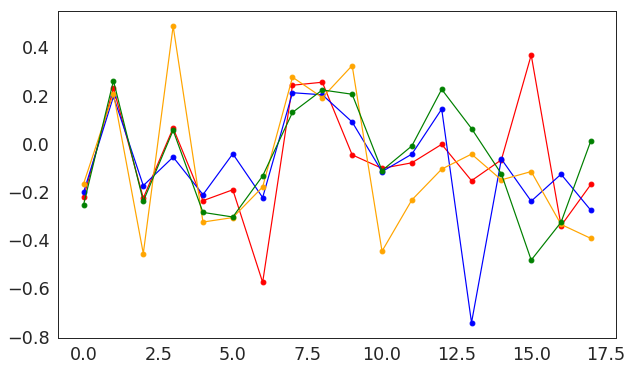

In [109]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(V[0, :], marker='o', color='red')
ax.plot(V[1, :], marker='o', color='blue')
ax.plot(V[16, :], marker='o', color='orange')
ax.plot(V[17, :], marker='o', color='green')


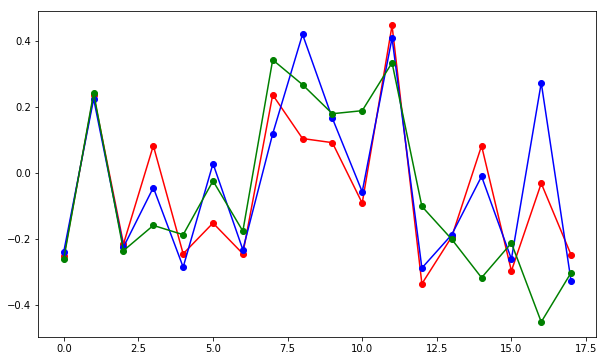

In [95]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(V[2, :], marker='o', color='red')
ax.plot(V[3, :], marker='o', color='blue')
ax.plot(V[4, :], marker='o', color='green')


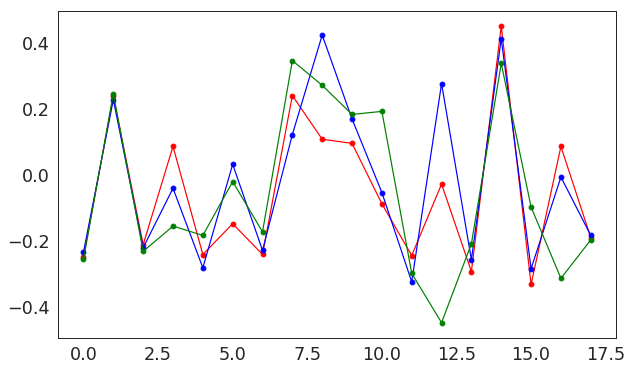

In [110]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(V[2, :], marker='o', color='red')
ax.plot(V[3, :], marker='o', color='blue')
ax.plot(V[4, :], marker='o', color='green')


(-0.7853981633974483, 0.7853981633974483)

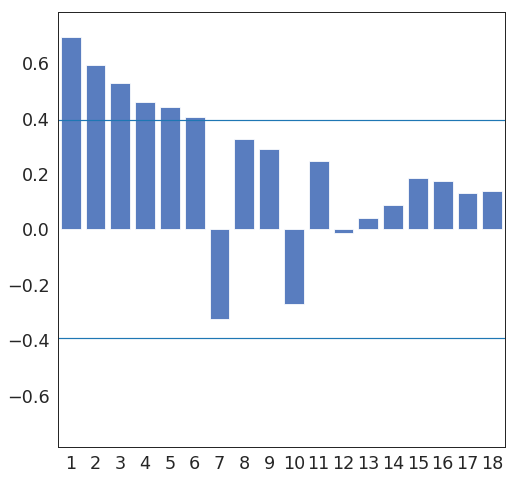

In [113]:
U, sigmas, V = calcHOGSVD([df_yeast.dropna().values, df_human.dropna().values])

angles = np.arctan2(np.diag(sigmas[0]), np.diag(sigmas[1])) - np.pi/4
fig, ax = plt.subplots(figsize=(8,8))
sns.set_color_codes("muted")

sns.barplot(x=np.arange(1, len(angles)+1), y=angles, ax=ax, color="b")
ax.axhline(y=np.pi/8)
ax.axhline(y=-np.pi/8)
ax.set_ylim(-np.pi/4, np.pi/4)



0 1


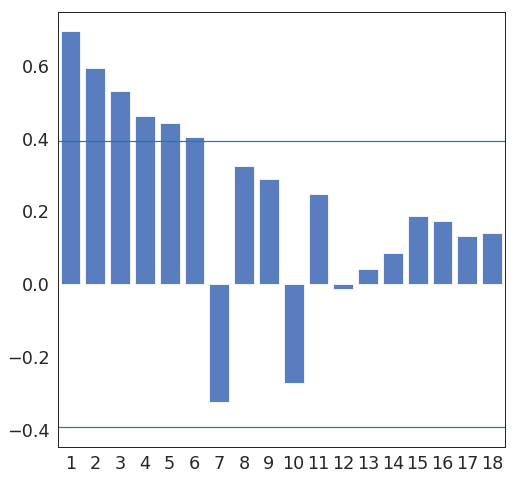

In [118]:
U, sigmas, V = calcHOGSVD([df_human.dropna().values, df_yeast.dropna().values])

angles = np.arctan2(np.diag(sigmas[0]), np.diag(sigmas[1])) - np.pi/4
fig, ax = plt.subplots(figsize=(8,8))
sns.set_color_codes("muted")

sns.barplot(x=np.arange(1, len(angles)+1), y=angles, ax=ax, color="b")
ax.axhline(y=np.pi/8)
ax.axhline(y=-np.pi/8)
#ax.set_ylim(-np.pi/4, np.pi/4)



In [93]:
highest_projection_genex_Y

array([2069, 3710, 2533, ..., 4087,  794, 2888])

In [ ]:
highest_projection_genex_Y

In [91]:
P_X_min_col[8773]

1.1400370069320316e-08

In [55]:
matrix1 = np.loadtxt('../hogsvd-python/A.txt')

params = {
    'K': matrix1.shape[1],
    'lambda1': 0.01,
    'mode': 2,
    'modeD': 0,   
    'posD': True,
    'posAlpha': True,
    'verbose': False
}

"""
 param = {
            'K': 2,
            'lambda1': self.lambda1,
            'mode': 2,
            'modeD': 0,
            'posD': True,
            'posAlpha': True,
            'verbose': False
        }
        stain_matrix = spams.trainDL(OD.T, **param).T
def get_concentrations(self, image, stain_matrix):
        OD = RGB2OD(image).reshape((-1, 3))
        if self.maskout_white:
            nonwhite_mask = get_nonwhite_mask(
                image, self.nonwhite_threshold).reshape((-1, ))
            OD = OD[nonwhite_mask]
        coefs = spams.lasso(
            OD.T, D=stain_matrix.T, mode=2, lambda1=self.lambda1,
            pos=True).toarray().T
        return coefs
"""        
        
matrix1_W = spams.trainDL(np.asfortranarray(matrix1), **params)
matrix1_H = spams.lasso(np.asfortranarray(matrix1), D=matrix1_W,
                        mode=2, lambda1=0.01,
                        pos=True).toarray()



In [56]:
matrix1_W.shape

(5, 5)

In [57]:
matrix1_H.shape

(5, 5)

In [58]:
matrix1_H

array([[0.        , 0.        , 0.        , 1.72398019, 0.        ],
       [0.        , 1.5440279 , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.50001829],
       [1.48127535, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 1.6297156 , 0.        , 0.        ]])

In [33]:
matrix1 = np.loadtxt('../hogsvd-python/A.txt')
matrix2 = np.loadtxt('../hogsvd-python/B.txt')
matrix3 = np.loadtxt('../hogsvd-python/C.txt')


In [34]:
U, sigmas, V = ho_SVD([matrix1, matrix2, matrix3])
sigmas

[array([[3.09280748, 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.37274234, 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.64861517, 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.99819793, 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.46047133]]),
 array([[0.0496686 , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 2.54977057, 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.5225826 , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.51731124, 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.83993335]]),
 array([[1.91481127, 0.        , 0.        , 0.        , 0.        ],
        [0.        , 2.10438386, 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.33562861, 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.65995043, 0.        ],
        [0.     

In [28]:
sigmas

[array([[1.88529753, 0.        , 0.        , 0.        , 0.        ],
        [0.        , 1.40617122, 0.        , 0.        , 0.        ],
        [0.        , 0.        , 1.1980833 , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 1.41909373, 0.        ],
        [0.        , 0.        , 0.        , 0.        , 1.53383005]]),
 array([[1.59284129, 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.85229232, 0.        , 0.        , 0.        ],
        [0.        , 0.        , 1.42873097, 0.        , 0.        ],
        [0.        , 0.        , 0.        , 1.27658053, 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.9030575 ]]),
 array([[0.7691295 , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 1.38869249, 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.88894246, 0.        , 0.        ],
        [0.        , 0.        , 0.        , 1.50545459, 0.        ],
        [0.     

In [17]:
def calcHOGSVD(matList):
    #assert len(matList)==3
    #Step 1: calculate Di^T*Di
    aMat = list()
    sMat = list()
    N = len(matList)
    for mat in matList:
        D = mat
        aMatTemp = np.dot(D.T, D)
        aMat.append(aMatTemp)

    #calculate pairwise Sij sums
    for i in range(len(aMat)):
        for j in range(i + 1, len(aMat)):
            print(i, j)
            sMatTemp = 0.5 * (np.dot(aMat[i], np.linalg.inv(aMat[j])) + np.dot(
                aMat[j], np.linalg.inv(aMat[i])))
            sMat.append(sMatTemp)

    S = np.zeros(sMat[0].shape)

    #sum all Si,j matrices to get S
    for s in sMat:
        S = S + s

    #normalize S
    S = (2.0 / (N * (N - 1))) * S

    #Do the eigen-decomposition on S
    L, V = np.linalg.eig(S)

    #Calculate the Bi matrices
    bMatList = list()
    for mat in matList:
        D = mat
        BT = np.dot(np.linalg.inv(V), D.T)
        bMatList.append(BT.T)

    #from Bi matrices calculate U and Sigma matrices
    sigList = list()
    uMatList = list()

    for B in bMatList:
        sig = np.sqrt(np.sum(B * B, axis=0))
        U = B / sig
        SIG = np.diag(sig)
        sigList.append(SIG)
        uMatList.append(U)

    return (uMatList, sigList, V)

In [19]:
U, sigmas, V =  calcHOGSVD([matrix1, matrix2, matrix3])
sigmas

0 1
0 2
1 2


[array([[3.09280748, 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.37274234, 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.64861517, 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.46047133, 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.99819793]]),
 array([[0.0496686 , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 2.54977057, 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.5225826 , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.83993335, 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.51731124]]),
 array([[1.91481127, 0.        , 0.        , 0.        , 0.        ],
        [0.        , 2.10438386, 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.33562861, 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.7093041 , 0.        ],
        [0.     